# Pfizer Vaccine Tweets

This dataset is from [Kaggle]('https://www.kaggle.com/gpreda/pfizer-vaccine-tweets'), compiled by user Gabriel Preda. I will be clustering the tweets to find any common themes among them, determining the sentiment of each tweet to see how the general public has reacted to the Pfizer BioNTech vaccine, and finally analyzing how sentiment has changed over time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import plotly.graph_objs as go
from datetime import datetime as dt


import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

import nltk
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def most_frequent(a_list): 
    return max(set(a_list), key = a_list.count)

In [3]:
tweets = pd.read_csv('vaccination_tweets.csv')
tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3945 entries, 0 to 3944
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                3945 non-null   int64 
 1   user_name         3945 non-null   object
 2   user_location     3119 non-null   object
 3   user_description  3698 non-null   object
 4   user_created      3945 non-null   object
 5   user_followers    3945 non-null   int64 
 6   user_friends      3945 non-null   int64 
 7   user_favourites   3945 non-null   int64 
 8   user_verified     3945 non-null   bool  
 9   date              3945 non-null   object
 10  text              3945 non-null   object
 11  hashtags          2934 non-null   object
 12  source            3944 non-null   object
 13  retweets          3945 non-null   int64 
 14  favorites         3945 non-null   int64 
 15  is_retweet        3945 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 439.3+ KB


In [5]:
#Convert data column to datetime for use later
tweets['user_created'] = pd.to_datetime(tweets['user_created'])
tweets['date'] = pd.to_datetime(tweets['date'])

tweets['account_age'] = tweets['date'] - tweets['user_created']

In [6]:
#Remove whitespace, URLs, and numbers
tweets['text'] = tweets['text'].str.strip()

tweets['no_url'] = tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
tweets["alpha_num"] = tweets["no_url"].str.replace("[^a-zA-Z ]", "", regex=True)

twitter_docs = list(tweets['alpha_num'])

In [7]:
def removeStopWords(stopWords, txt):
    newtxt = ' '.join([word for word in txt.split() if word not in stopWords])
    return newtxt


from nltk.corpus import stopwords
stops = stopwords.words("English")
stop_set = ['vaccine', 'vaccines', 'vaccination', 'vaccinated', 'pfizerbiontech', 'covid_vaccine',
            'covid19', 'pfizer', 'coronavirus', 'covidvaccine', 'covid', 'pfizercovidvaccine', 'get',
           'pfizervaccine', 'biontech', 'PfizerBioNTech', 'vaccinations']
for word in stop_set:
    stops.append(word)

twitter_docs = [doc.lower() for doc in twitter_docs]
tweets_processed = [removeStopWords(stops,x) for x in twitter_docs]

In [8]:
embeddings = embed(tweets_processed).numpy()

In [9]:
embedding_df = pd.DataFrame(embeddings)
embedding_df['tweet'] = tweets_processed

# Dimension Reduction for Visualizations

Using UMAP and PCA, I will reduce the dimensions for visualization purposes only. The actual clustering will be done on the raw data.

In [11]:
dbscan_eps = 0.5
dbscan_min_samples = 20
k = 10

In [12]:
from umap import UMAP
X = embedding_df.drop('tweet', axis = 1)

umap = UMAP(n_components = 2, n_neighbors = 10)
components_umap = umap.fit_transform(X)


embeddings_2d = pd.DataFrame(components_umap, columns=['x1', 'x2'])
embeddings_2d['tweet'] = tweets_processed

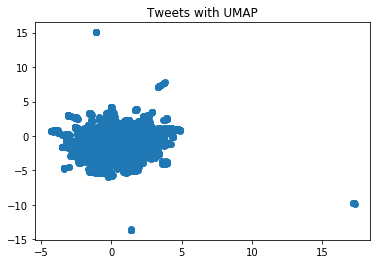

In [13]:
plt.scatter(data = embeddings_2d, x = 'x1', y = 'x2')
plt.title('Tweets with UMAP')
plt.show()

In [14]:
X = embedding_df.drop('tweet', axis =1)
pca = PCA(n_components = 2)
pca_components = pca.fit_transform(X)

embeddings_2d_pca = pd.DataFrame(pca_components, columns=['x1', 'x2'])
embeddings_2d_pca['tweet'] = tweets_processed


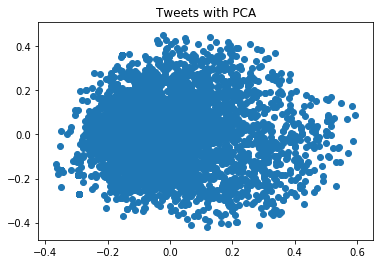

In [15]:
plt.scatter(data = embeddings_2d_pca, x = 'x1', y = 'x2')
plt.title('Tweets with PCA')
plt.show()

# DBSCAN

In [16]:
X = embedding_df.drop('tweet', axis = 1)
dbscan = DBSCAN(eps = dbscan_eps, min_samples = dbscan_min_samples, metric ='cosine')
dbscan.fit(X)

DBSCAN(metric='cosine', min_samples=20)

In [17]:
embeddings_2d['cluster'] = dbscan.labels_
embeddings_2d['cluster'].value_counts()

-1    2951
 0     690
 6      66
 3      58
 2      39
 5      29
 8      28
 7      22
 4      22
 9      20
 1      20
Name: cluster, dtype: int64

In [18]:
embeddings_2d['tweet'] = tweets_processed
embeddings_2d_pca['tweet'] = tweets_processed

In [19]:
dbscan_umap = embeddings_2d[embeddings_2d['cluster'] != -1]
dbscan_pca = embeddings_2d_pca
dbscan_pca['cluster'] = dbscan.labels_
dbscan_pca = dbscan_pca[dbscan_pca['cluster'] != -1]

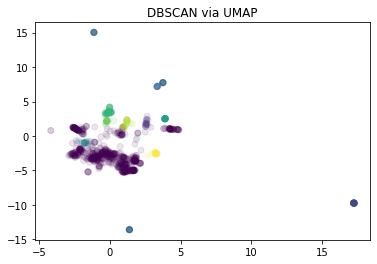

In [20]:
plt.scatter(data = dbscan_umap, x = 'x1', y = 'x2', c = 'cluster', alpha = 0.1)
plt.title('DBSCAN via UMAP')
plt.show()

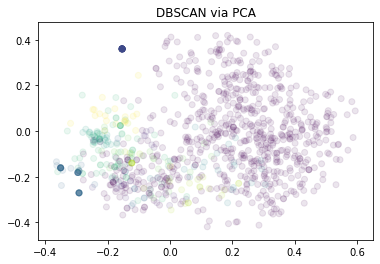

In [21]:
plt.scatter(data = dbscan_pca, x = 'x1', y = 'x2', c = 'cluster', alpha = 0.1)
plt.title('DBSCAN via PCA')
plt.show()

In [22]:
dbscan_full = embedding_df.copy()
dbscan_full['cluster'] = dbscan.labels_
dbscan_full = dbscan_full[dbscan_full['tweet'] != '']

In [23]:
cluster_map = {}
for cluster in dbscan_full['cluster'].unique():
    cluster_text = dbscan_full[dbscan_full['cluster'] == cluster]['tweet']
    test_tokens = [nltk.word_tokenize(tweet) for tweet in cluster_text]
    test_flat =[token for sublist in test_tokens for token in sublist]
    cluster_map[cluster] = most_frequent(test_flat)

In [24]:
dbscan_full['label'] = dbscan_full['cluster'].map(cluster_map)
dbscan_full['cluster'].unique()

array([-1,  3,  1,  0,  4,  7,  9,  5,  6,  8], dtype=int64)

In [25]:
dbscan_full['label'].value_counts()

first        2951
dose          690
dubai          66
ban            58
emegency       29
million        28
frontline      22
singapore      22
use            20
moderna        20
Name: label, dtype: int64

# KMeans

In [26]:
X = embedding_df.drop('tweet', axis = 1)

kmeans = KMeans(n_clusters = k)
kmeans.fit(X)

KMeans(n_clusters=10)

In [27]:
embeddings_2d['cluster'] = kmeans.labels_
print(embeddings_2d['cluster'].value_counts())

kmeans_clusters = embeddings_2d[embeddings_2d['cluster'] != -1]
kmeans_pca = embeddings_2d_pca.copy()
kmeans_pca['cluster'] = kmeans.labels_

3    658
6    655
1    577
7    505
4    452
8    405
9    254
2    166
5    159
0    114
Name: cluster, dtype: int64


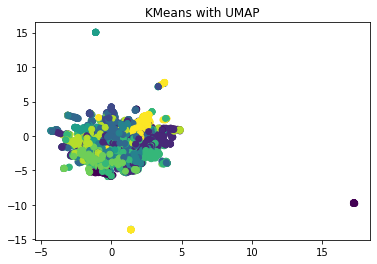

In [28]:
plt.scatter(data = kmeans_clusters, x = 'x1', y = 'x2', c = 'cluster')
plt.title('KMeans with UMAP')
plt.show()

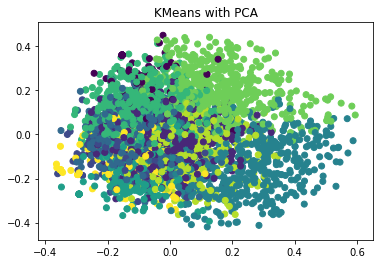

In [29]:
plt.scatter(data = kmeans_pca, x = 'x1', y = 'x2', c = 'cluster')
plt.title('KMeans with PCA')
plt.show()

In [30]:
cluster_map = {}
for cluster in kmeans_clusters['cluster'].unique():
    cluster_text = kmeans_clusters[kmeans_clusters['cluster'] == cluster]['tweet']
    test_tokens = [nltk.word_tokenize(tweet) for tweet in cluster_text]
    test_flat =[token for sublist in test_tokens for token in sublist]
    cluster_map[cluster] = most_frequent(test_flat)

In [31]:
kmeans_clusters['label'] = kmeans_clusters['cluster'].map(cluster_map)
kmeans_clusters.head(2)

,x1,x2,tweet,cluster,label
0,3.125819,-0.855023,folks said daikon paste could treat cytokine s...,3,first
1,0.136082,-1.479209,world wrong side history year hopefully bigges...,3,first


In [32]:
kmeans_clusters['label'].value_counts()

first      1063
moderna     655
mrna        577
today       505
dose        452
use         254
dubai       166
norway      159
got         114
Name: label, dtype: int64

KMeans gives worse separation between clusters, so DBSCAN is the better choice for this project.

# Sentiment Analysis

In [33]:
tokens = [nltk.word_tokenize(tweet) for tweet in tweets_processed]
flat_tokens = [token for sublist in tokens for token in sublist]

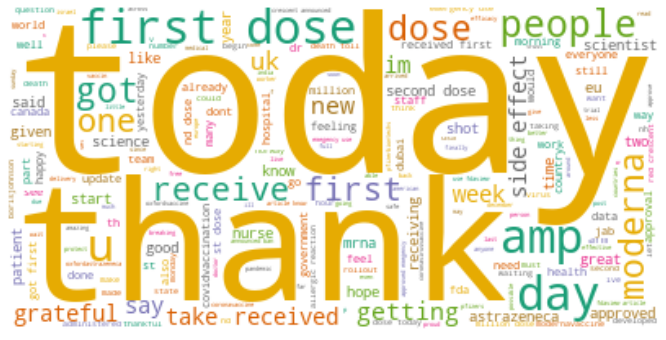

In [34]:
wc = WordCloud(stopwords=stops, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(flat_tokens)))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")    
plt.show()

From the word cloud, it appears that most of these tweets are about being thankful for recieving the first dose of the vaccine on the day the user tweeted.

In [35]:
unique_tokens = []
for token in flat_tokens:
    if token not in unique_tokens:
        unique_tokens.append(token)
        
        
unique_tokens.sort()

In [36]:
#creates a vector for each unique token in the tweets
vectorizer = CountVectorizer(analyzer = "word", 
                             preprocessor = None, 
                             stop_words =  'english', 
                             max_features = len(unique_tokens), ngram_range=(1,5))
data_features = vectorizer.fit_transform(tweets_processed)
tfidf_transformer = TfidfTransformer()
data_features_tfidf = tfidf_transformer.fit_transform(data_features)
data_mat = data_features_tfidf.toarray()
data_mat_df = pd.DataFrame(data_mat)
data_mat_df['tweet'] = tweets_processed

In [37]:
sparse_df = pd.DataFrame.sparse.from_spmatrix(data_features)
sparse_df['tweet'] = tweets_processed
sparse_df.shape

(3945, 8357)

There is one row for each tweet and one column for each unique word in the corpus

From TextBlob [docs](https://textblob.readthedocs.io/en/dev/quickstart.html):

"The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective."

For this project, I will only be working with polarity.

In [38]:
#Create polarity function and subjectivity function
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
pol_list = [pol(x) for x in tweets_processed]
sub_list = [sub(x) for x in tweets_processed]

In [39]:
#Assign labels for polarity
sentiment_list = []
for i in range(len(pol_list)):
    if pol_list[i] > 0:
        sentiment_list.append('Positive')
    elif pol_list[i] < 0:
        sentiment_list.append('Negative')
    else:
        sentiment_list.append('Neutral')

In [40]:
sparse_df['sentiment'] = sentiment_list
sparse_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,8348,8349,8350,8351,8352,8353,8354,8355,tweet,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,folks said daikon paste could treat cytokine s...,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,world wrong side history year hopefully bigges...,Negative


In [41]:
for cluster in sparse_df['sentiment'].unique():
    cluster_text = sparse_df[sparse_df['sentiment'] == cluster]['tweet']
    test_tokens = [nltk.word_tokenize(tweet) for tweet in cluster_text]
    test_flat =[token for sublist in test_tokens for token in sublist]
    print(f'Most frequent word in {cluster}: {most_frequent(test_flat)}')

Most frequent word in Neutral: dose
Most frequent word in Negative: dose
Most frequent word in Positive: first


# Classifying Sentiment

In [42]:
X = sparse_df.drop(columns =['tweet', 'sentiment'])
y = sparse_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 21)

## RandomForest

In [43]:
rf_model_0 = RandomForestClassifier()
rf_model_0.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
y_pred = rf_model_0.predict(X_test)

In [45]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns =['Pred Neg', 'Pred Neu', 'Pred Pos'], index = ['True Neg', 'True Neu', 'True Pos'])

,Pred Neg,Pred Neu,Pred Pos
True Neg,31,29,18
True Neu,0,377,16
True Pos,5,81,232


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.86      0.40      0.54        78
     Neutral       0.77      0.96      0.86       393
    Positive       0.87      0.73      0.79       318

    accuracy                           0.81       789
   macro avg       0.84      0.70      0.73       789
weighted avg       0.82      0.81      0.80       789



This model performs fairly well, but I'll experient with hyperparams just to see if it can get even better.

In [62]:
rf_model_1 = RandomForestClassifier(n_estimators = 300, criterion = 'gini')
rf_model_1.fit(X_train, y_train)
y_pred = rf_model_1.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), columns =['Pred Neg', 'Pred Neu', 'Pred Pos'], index = ['True Neg', 'True Neu', 'True Pos'])

,Pred Neg,Pred Neu,Pred Pos
True Neg,31,31,16
True Neu,0,381,12
True Pos,2,83,233


In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.94      0.40      0.56        78
     Neutral       0.77      0.97      0.86       393
    Positive       0.89      0.73      0.80       318

    accuracy                           0.82       789
   macro avg       0.87      0.70      0.74       789
weighted avg       0.84      0.82      0.81       789



The second model performs slightly better.

## KNeighborsClassifier

In [ ]:
knn_0 = KNeighborsClassifier()
knn_0.fit(X_train, y_train)

In [ ]:
y_pred_0 = knn_0.predict(X_test)

In [ ]:
pd.DataFrame(confusion_matrix(y_test, y_pred_0), columns =['Pred Neg', 'Pred Neu', 'Pred Pos'], index = ['True Neg', 'True Neu', 'True Pos'])

In [ ]:
print(classification_report(y_test, y_pred_0))

This model is super underfit, so I'll try adjusting the hyperparameters.

In [ ]:
knn_0 = KNeighborsClassifier()
knn_0.fit(X_train, y_train)
y_pred_0 = knn_0.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred_0), columns =['Pred Neg', 'Pred Neu', 'Pred Pos'], index = ['True Neg', 'True Neu', 'True Pos'])

# Sentiment Over Time

In [ ]:
tweets['sentiment'] = sentiment_list

In [ ]:
tweets['date'] = pd.to_datetime(tweets['date'])
for i in range(len(tweets['date'])):
    tweets['date'][i] = dt.strftime(tweets['date'][i], '%m/%d/%Y')
    
tweets['date'] = pd.to_datetime(tweets['date'])

In [ ]:
sent_by_date = tweets[['date', 'sentiment']]
sent_by_date['count'] = [1 for i in range(len(tweets))]


In [ ]:
df = pd.pivot_table(sent_by_date, values = 'count', index=['date'], columns = 'sentiment', aggfunc=np.sum)
fig = go.Figure()
for col in df.columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True
                             ))
                  
fig.update_layout(title ='Opinion of Tweets on Pfizer COVID-19 Vaccine')
fig.update_xaxes(title = 'Date')
fig.update_yaxes(title = 'Number of Tweets')


The trends of each type of tweet generally follow the same trend. There is a sharp decrease in all types of tweets on December 25th. Interestingly, the number of total tweets peaks on January 9th, the same day as the Capitol Riots.

In [ ]:
tweets['cluster'] = dbscan_full['cluster']
tweets['label'] = dbscan_full['label']
tweets['pol'] = pol_list

In [ ]:
#Find the average age of accounts per sentiment group
tweets_age = tweets[['account_age', 'sentiment', 'text', 'user_verified', 'cluster', 'label']]
tweets_age['pol'] = pol_list
tweets_age = tweets_age[tweets_age['cluster'] != -1.0]
tweets_age['user_verified'] = tweets_age['user_verified'].astype(int)

In [ ]:
grouped = tweets_age.groupby('sentiment')
mean = grouped.apply(lambda x: np.mean(x))
mean[['account_age']]

In [ ]:
grouped['account_age'].min()

The Negative tweets have the youngest average account age of 5.75 years. Neutral tweets come from accounts with an average age of 6.15 years, and Positive tweets come from accounts with an average age of 6.96 years. However, the youngest account in each group do not follow this pattern. The Neutral group had the youngest account of only 5 minutes. 

In [ ]:
#Find the overall sentiment per cluster given by DBSCAN
tweets_age.dropna(inplace=True)
for cluster in tweets_age['cluster'].unique():
    group = tweets_age[tweets_age['cluster'] == cluster]
    label = group['label'].values[0]
    avg_pol = group['pol'].mean()
    print(f"Cluster: {cluster} - {label}")
    if avg_pol > 0:
        print('Average sentiment: Positive')
    elif avg_pol < 0:
            print('Average sentiment: Negative')
    else:
        print('Average sentiment: Neutral')
    print('---------------------------------------')

DBSCAN clustered the tweets in such a way that most clusters have an overall positive sentiment even though the majority of tweets are neutral. This also tells us that the tweets mentioning the Moderna vaccine are largely positive as well.

# Verified vs Non-Verified Users

In [ ]:
grouped = tweets_age.groupby('sentiment')
mean = grouped.apply(lambda x: np.mean(x))
mean[['user_verified']]


In [ ]:
sns.countplot(data = tweets_age, x = 'sentiment', hue='user_verified')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Tweet Sentiment by Verified Users')
plt.legend(['Not Verified', 'Verified'])
plt.show()

The majority of verified users tweet positive tweets about the Pfizer vaccine. Further work could include statistical tests to determine whether a significant difference between verified and non-verified users exist.

# Conclusion

The majority of these tweets are neutral, and are likely news sources simply reporting updates on the vaccine. The positive tweets come 

# Further Work

To gauge the accuracy of TextBlob's sentiment function, it would be necessary to manually label each tweet as positive, negative, or neutral. Additionally, other classifiers such as SVC should be tried to get the best accuracy.

It would also be interesting to work with the subjectivity aspect of the sentiment function to see if this affects how the tweets are labeled.

Further work could also include looking for seasonality in the sentiment of tweets as more data is collected.